In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [9]:
# leer archivo CSV

strava_marta = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\data\activities_marta_zapatero.csv")

# mostrar las primeras filas del DataFrame

strava_marta.head()

,ID de actividad,Fecha de la actividad,Nombre de la actividad,Tipo de actividad,Descripción de la actividad,Tiempo transcurrido,Distancia,Ritmo cardiaco máximo,Esfuerzo Relativo,Desplazamiento,...,Intensidad,Ritmo ajustado en pendientes promedio,Tiempo cronometrado,Ciclos en total,Recuperación,Con mascota,Competición,Carrera de larga distancia,Por una causa,Multimedia
0,11726066374,24 jun. 2024 9:30:34,Carrera a la hora del almuerzo,Carrera,NaN,1660,"5,15",NaN,NaN,False,...,NaN,3.109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11820245512,6 jul. 2024 9:37:44,Carrera a la hora del almuerzo,Carrera,NaN,1259,"4,10",NaN,NaN,False,...,NaN,3.266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12084835783,7 ago. 2024 10:05:54,Carrera a la hora del almuerzo,Carrera,NaN,1038,"3,40",NaN,NaN,False,...,NaN,3.307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12143976236,14 ago. 2024 9:38:39,Carrera a la hora del almuerzo,Carrera,NaN,1588,"5,07",NaN,NaN,False,...,NaN,3.205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12169203904,17 ago. 2024 10:08:00,Carrera a la hora del almuerzo,Carrera,NaN,1586,"5,08",NaN,NaN,False,...,NaN,3.211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# variable distancia a float
strava_marta['Distancia'] = strava_marta['Distancia'].replace(',', '.', regex=True).astype(float)

In [11]:
def limpiar_strava(df):
    # Renombrar columnas para facilitar el manejo
    df = df.rename(columns={
        'Fecha de la actividad': 'activity_date',
        'Tipo de actividad': 'activity_type',
        'Nombre de la actividad': 'activity_name',
        'Distancia': 'distance',
        'Tiempo transcurrido': 'elapsed_time',
        'Velocidad promedio': 'average_speed',
        'Desnivel positivo': 'elevation_gain',
        'Ritmo cardiaco promedio': 'avg_heart_rate',
        'Ritmo cardiaco máximo': 'max_heart_rate',
        'Calorías': 'calories',
        'Cadencia promedio': 'avg_cadence',
        'ID de actividad': 'activity_id',
    })

    # Convertir activity_date a datetime
    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df[(df['activity_date'].dt.year >= 2024) & (df['activity_type'] == 'Carrera')]

    if df['distance'].max() > 1000:
        df['distance_km'] = df['distance'] / 1000
    else:
        df['distance_km'] = df['distance']

    # Calcular el ritmo promedio en segundos por km
    df['avg_pace_s_per_km'] = df['elapsed_time'] / df['distance_km']

    # Calcular el ritmo en minutos por km
    df['minutes_per_km'] = df['avg_pace_s_per_km'] / 60

    # Función simple para formatear ritmo
    def format_pace(minutes_per_km):
        if pd.isna(minutes_per_km) or minutes_per_km <= 0:
            return "N/A"
        minutes = int(minutes_per_km)
        seconds = int(round((minutes_per_km - minutes) * 60))
        if seconds == 60:
            minutes += 1
            seconds = 0
        return f"{minutes}.{seconds:02d}"

    # Aplicar formato de ritmo
    df['pace_formatted'] = df['minutes_per_km'].apply(format_pace)
    # cambiarla a float
    df['pace_formatted'] = df['pace_formatted'].replace("N/A", np.nan).astype(float)

    # Nueva columna: elapsed_time en formato hh:mm:ss (sin días)
    df['elapsed_time_hms'] = pd.to_timedelta(df['elapsed_time'], unit='s').apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}:{int(x.total_seconds() % 60):02}")

    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km','elapsed_time_hms',
        'pace_formatted','elevation_gain', 'avg_cadence','avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    df = df[columnas]

    return df

strava_limpio = limpiar_strava(strava_marta)

C:\Users\eduar\AppData\Local\Temp\ipykernel_20920\2403420217.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')


In [12]:
# añadir columna usuario

strava_limpio['user'] = 'Marta'

In [13]:
# ver dataframe

strava_limpio.tail()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user
44,15023050053,2025-07-06 09:26:11,Carrera,5.02,00:26:56,5.22,15.6,NaN,NaN,NaN,NaN,Marta
45,15080007735,2025-07-11 14:58:44,Carrera,4.00,00:22:53,5.43,13.3,NaN,NaN,NaN,NaN,Marta
46,15239793104,2025-07-26 09:29:24,Carrera,5.11,00:28:58,5.40,23.8,NaN,NaN,NaN,NaN,Marta
47,15285241464,2025-07-30 11:08:27,Carrera,5.52,00:31:42,5.45,19.9,NaN,NaN,NaN,NaN,Marta
50,15838605842,2025-09-17 04:35:19,Carrera,5.04,00:28:48,5.43,38.7,NaN,NaN,NaN,NaN,Marta


In [14]:
# Guardar el DataFrame limpio en la carpeta csv_clean
strava_limpio.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\csv_clean\strava_marta_zapatero_limpio.csv", index=False)

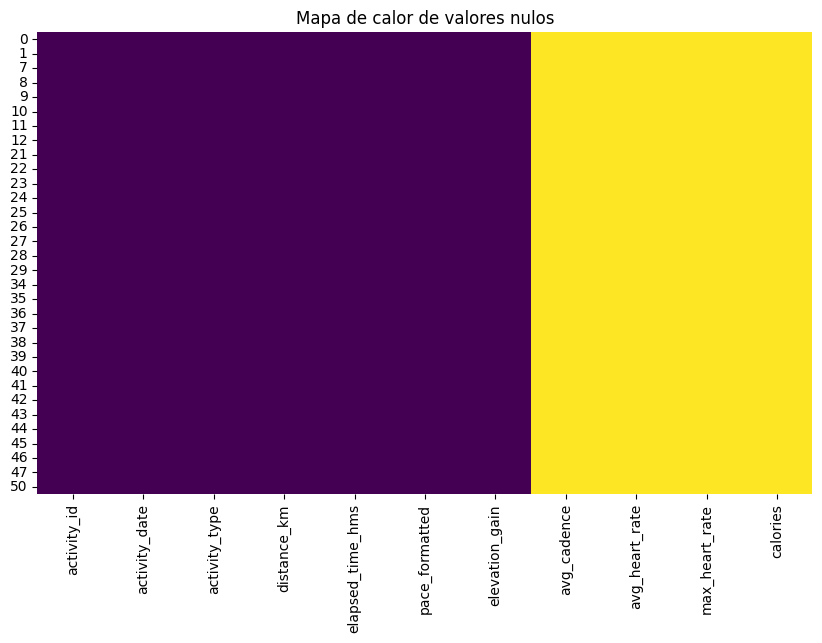

Estadísticos de variables seleccionadas:
       distance_km  pace_formatted  calories
count    32.000000       32.000000       0.0
mean      5.407500        5.505312       NaN
std       1.741642        0.321177       NaN
min       2.230000        5.070000       NaN
25%       5.010000        5.317500       NaN
50%       5.105000        5.430000       NaN
75%       5.460000        5.507500       NaN
max      10.190000        6.400000       NaN


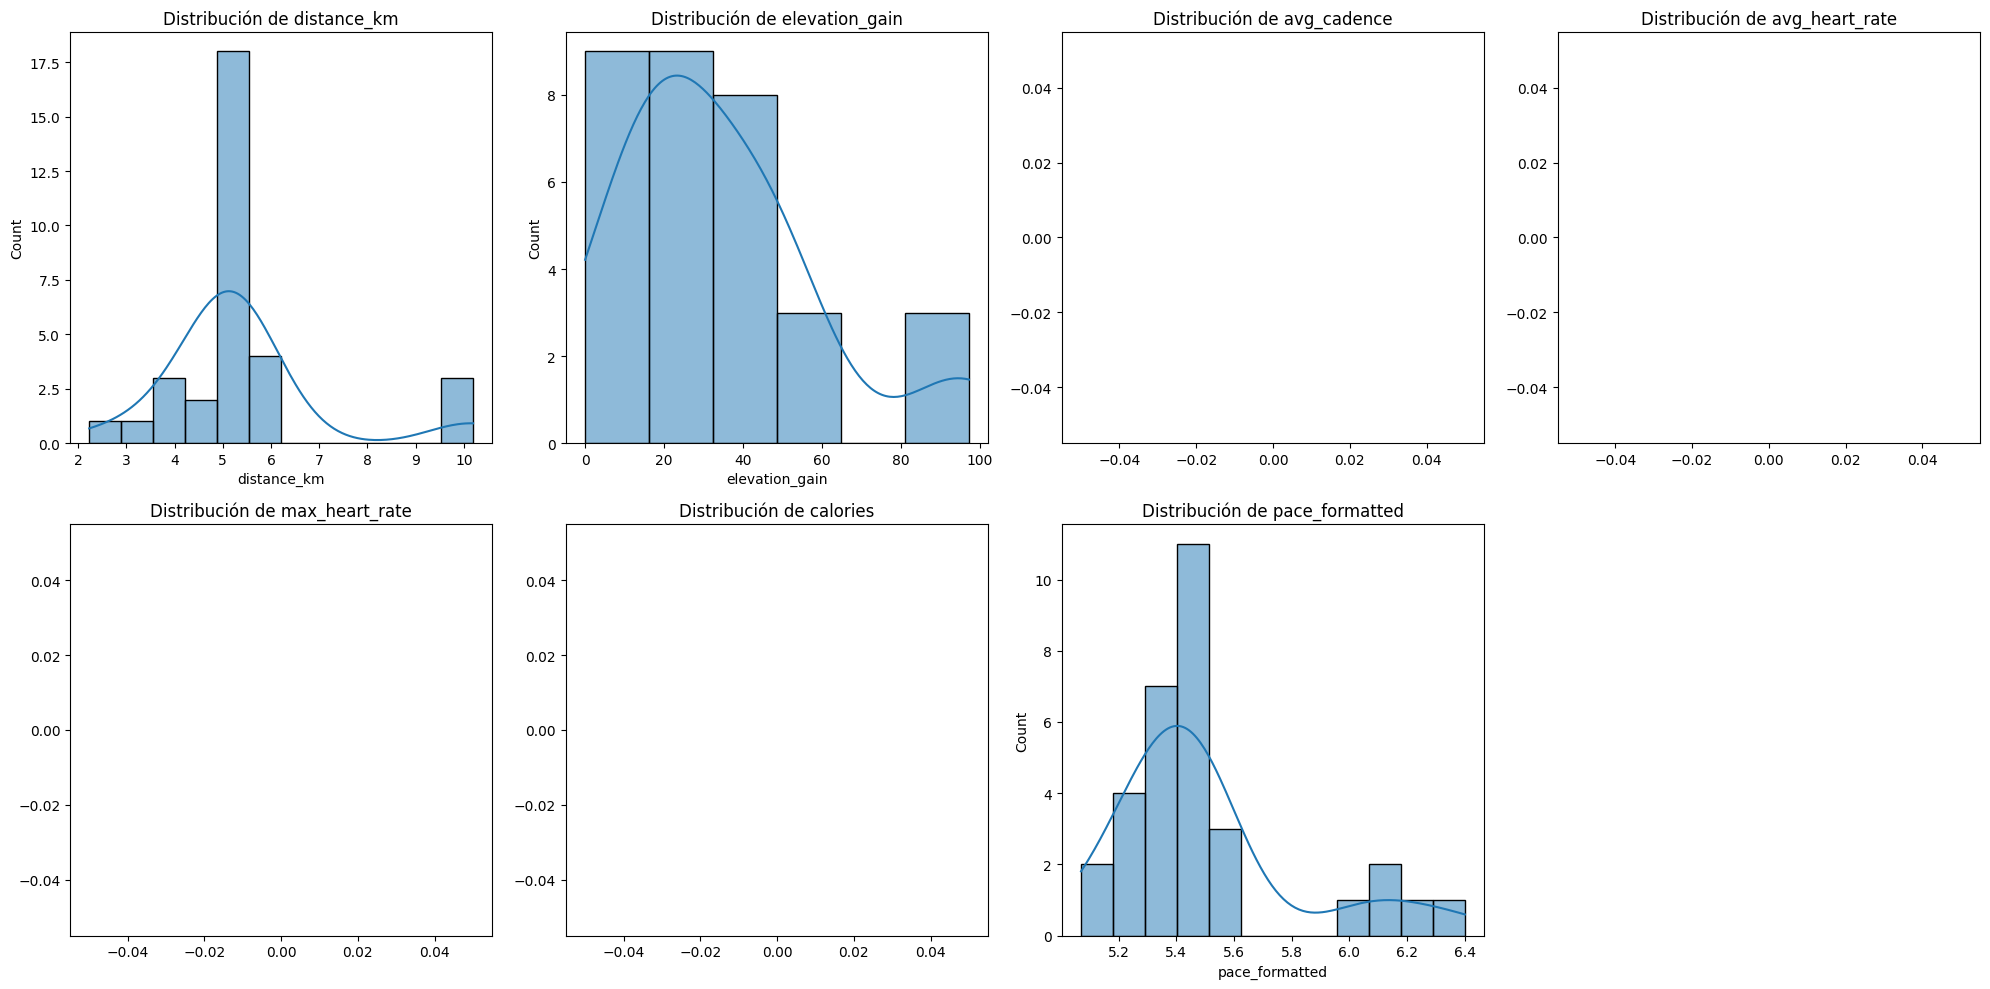

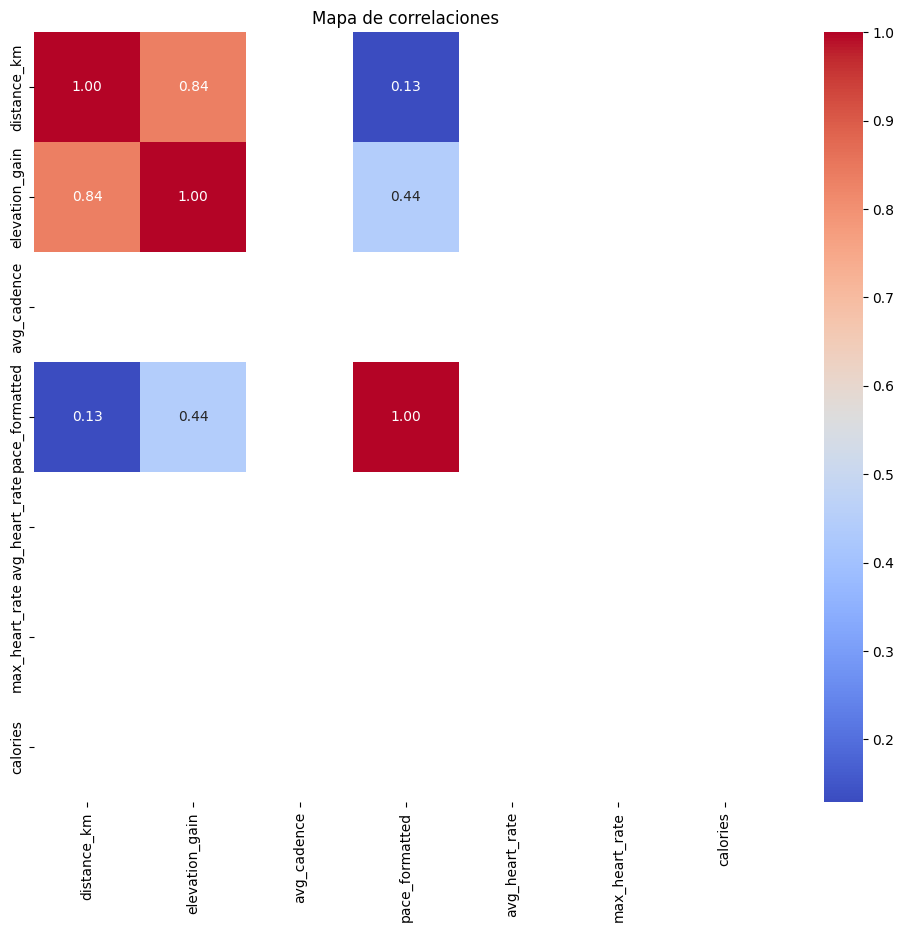

In [15]:
def EDA(data):
    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km', 'elapsed_time_hms',
        'pace_formatted', 'elevation_gain', 'avg_cadence',
        'avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['distance_km', 'pace_formatted', 'calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['distance_km', 'elevation_gain', 'avg_cadence', 'avg_heart_rate', 'max_heart_rate', 'calories', 'pace_formatted']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')

    # Eliminar el subplot vacío si hay menos variables que subplots
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['distance_km', 'elevation_gain', 'avg_cadence','pace_formatted', 'avg_heart_rate', 'max_heart_rate', 'calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA(strava_limpio)
